In [99]:
import tensorflow as tf

In [36]:
print(tf.__version__)

2.16.1


In [100]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [101]:
df =  pd.read_csv('Brent_Oil_Futures_Historical_Data.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/27/1988,15.10,15.10,15.10,15.10,0.05K,-3.51%
1,06/28/1988,15.27,15.34,15.36,15.27,0.16K,1.13%
2,06/29/1988,15.47,15.47,15.47,15.47,NaN,1.31%
3,06/30/1988,14.85,14.80,14.90,14.80,0.42K,-4.01%
4,07/01/1988,14.60,14.60,14.60,14.60,0.05K,-1.68%


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9129 entries, 0 to 9128
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      9129 non-null   object 
 1   Price     9129 non-null   float64
 2   Open      9129 non-null   float64
 3   High      9129 non-null   float64
 4   Low       9129 non-null   float64
 5   Vol.      9123 non-null   object 
 6   Change %  9129 non-null   object 
dtypes: float64(4), object(3)
memory usage: 499.4+ KB


In [103]:
unit_mapping = {'K': 1000}

def convert_to_numeric(value):
    if isinstance(value, str) and value[-1] in unit_mapping:
        unit = value[-1]
        number = float(value[:-1])
        return number * unit_mapping[unit]
    elif isinstance(value, str):
        return float(value)
    else:
        return value

def remove_percentage(value):
    if isinstance(value, str) and value[-1] == '%':
        return float(value[:-1])
    else:
        return value

df['Change %'] = df['Change %'].apply(remove_percentage)
df['Vol.'] = df['Vol.'].apply(convert_to_numeric)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/27/1988,15.10,15.10,15.10,15.10,50.0,-3.51
1,06/28/1988,15.27,15.34,15.36,15.27,160.0,1.13
2,06/29/1988,15.47,15.47,15.47,15.47,NaN,1.31
3,06/30/1988,14.85,14.80,14.90,14.80,420.0,-4.01
4,07/01/1988,14.60,14.60,14.60,14.60,50.0,-1.68


In [104]:
imputer = SimpleImputer(strategy='mean')
df['Vol.'] = imputer.fit_transform(df[['Vol.']])

In [105]:
df.reset_index(drop=True, inplace=True)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9129 entries, 0 to 9128
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      9129 non-null   object 
 1   Price     9129 non-null   float64
 2   Open      9129 non-null   float64
 3   High      9129 non-null   float64
 4   Low       9129 non-null   float64
 5   Vol.      9129 non-null   float64
 6   Change %  9129 non-null   float64
dtypes: float64(6), object(1)
memory usage: 499.4+ KB


In [107]:
train_size = int(len(df) * 0.8)
training_data = df[:train_size]
testing_data = df[train_size:]

In [108]:
x_train_cols = training_data.iloc[:, 1:7].values  
y_train_col = training_data.iloc[:, 1].values

In [109]:
sc = MinMaxScaler(feature_range=(0,1))
x_train_scaled = sc.fit_transform(x_train_cols)

In [47]:
with open('./models/MERGE.pkl', 'wb') as f:
    pickle.dump(sc, f)

In [48]:
x_train_scaled

array([[4.00175901e-02, 3.95314788e-02, 3.74409306e-02, 4.12026726e-02,
        8.62440707e-05, 6.40311348e-01],
       [4.12635591e-02, 4.12884334e-02, 3.93311523e-02, 4.24647365e-02,
        3.23415265e-04, 7.35354363e-01],
       [4.27294049e-02, 4.22401171e-02, 4.01308615e-02, 4.39495174e-02,
        2.40647380e-01, 7.39041376e-01],
       ...,
       [3.37950748e-01, 3.37628111e-01, 3.36604871e-01, 3.41573868e-01,
        5.87559293e-01, 7.04219582e-01],
       [3.37217825e-01, 3.37042460e-01, 3.36532170e-01, 3.38381589e-01,
        6.70181113e-01, 7.08521098e-01],
       [3.38390501e-01, 3.36969253e-01, 3.33914940e-01, 3.38158872e-01,
        5.83182406e-01, 7.18148300e-01]])

In [49]:
x_train = []
y_train = []

for i in range(60, len(training_data) - 1):
    x_train.append(x_train_scaled[i-60:i+1, :]) 
    y_train.append(y_train_col[i+1])

x_train, y_train = np.array(x_train), np.array(y_train)

In [50]:
x_train

array([[[4.00175901e-02, 3.95314788e-02, 3.74409306e-02, 4.12026726e-02,
         8.62440707e-05, 6.40311348e-01],
        [4.12635591e-02, 4.12884334e-02, 3.93311523e-02, 4.24647365e-02,
         3.23415265e-04, 7.35354363e-01],
        [4.27294049e-02, 4.22401171e-02, 4.01308615e-02, 4.39495174e-02,
         2.40647380e-01, 7.39041376e-01],
        ...,
        [3.00498388e-02, 2.92825769e-02, 2.84987277e-02, 3.07349666e-02,
         3.49288486e-03, 6.81278165e-01],
        [2.79976546e-02, 2.70131772e-02, 2.54452926e-02, 2.73199703e-02,
         4.26908150e-03, 6.70421958e-01],
        [2.90237467e-02, 2.79648609e-02, 2.72628135e-02, 2.94729027e-02,
         1.18585597e-03, 7.33510856e-01]],

       [[4.12635591e-02, 4.12884334e-02, 3.93311523e-02, 4.24647365e-02,
         3.23415265e-04, 7.35354363e-01],
        [4.27294049e-02, 4.22401171e-02, 4.01308615e-02, 4.39495174e-02,
         2.40647380e-01, 7.39041376e-01],
        [3.81852829e-02, 3.73352855e-02, 3.59869138e-02, 3.897550

In [51]:
y_train

array([13.52, 13.58, 13.52, ..., 55.75, 55.65, 55.81])

In [52]:
x_train.shape

(7242, 61, 6)

In [67]:
# Define the input layer common to all models
input_layer = tf.keras.layers.Input(shape=(61, 6))

# Model 1: GRU
gru_output = tf.keras.Sequential([
    tf.keras.layers.GRU(units=60, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=60, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=80, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=120, activation='relu'),
    tf.keras.layers.Dropout(0.2)
])(input_layer)

# Model 2: DNN
dnn_output = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(61, 6)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),  
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation='relu'),  
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=128, activation='relu'),  
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='relu'),  
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)  
])(input_layer)

# Concatenate the outputs of the two models
concatenated_outputs = tf.keras.layers.Concatenate()([gru_output, dnn_output])

# Final decision layers
final_output = tf.keras.layers.Dense(units=64, activation='relu')(concatenated_outputs)
final_output = tf.keras.layers.Dropout(0.2)(final_output)
final_output = tf.keras.layers.Dense(units=1)(final_output)

# Create the merged model
model = tf.keras.Model(inputs=input_layer, outputs=final_output)

# Model summary to check the architecture
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 61, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 120)       │    141,000 │ input_layer_13[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 1)         │    200,961 │ input_layer_13[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 121)       │          0 │ sequential_10[0]… │
│ (Concatenate)       │                   │            │ sequential_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │      7,808 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 64)        │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │         65 │ dropout_50[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 349,834 (1.33 MB)

 Trainable params: 349,834 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
checkpoint = ModelCheckpoint('./models/MERGE.keras', monitor='loss', verbose=1, save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logs'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

In [69]:
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))

In [70]:
model.fit(x_train, y_train, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1720.5500
Epoch 1: loss improved from inf to 789.79071, saving model to ./models/MERGE.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 1712.4565 - learning_rate: 0.0010
Epoch 2/150
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 177.8619
Epoch 2: loss improved from 789.79071 to 152.20810, saving model to ./models/MERGE.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 177.4157 - learning_rate: 0.0010
Epoch 3/150
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 124.7544
Epoch 3: loss improved from 152.20810 to 110.50861, saving model to ./models/MERGE.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 124.6305 - learning_rate: 0.0010
Epoch 4/150
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 72.0330
Epoch 4: loss improved from 110.50861 to 70.90298, saving model to ./models/MERGE.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 72.0133 - learning_rate: 0.0010
Epoch 5/150
113/114 ━━━━━━━━━━━━━━━

In [57]:
real_price = testing_data.iloc[:, 1].values

In [58]:
real_price.shape

(1826,)

In [59]:
predictions = []
for i in range(len(testing_data)):
    input_data_test = testing_data.iloc[i, 1:7].values.reshape(1, -1).repeat(61, axis=0) 
    input_data_test_scaled = sc.transform(input_data_test).reshape(1, 61, 6)
    predicted_price_test = model.predict(input_data_test_scaled)
    predictions.append(predicted_price_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [60]:
predictions = np.array(predictions).reshape(-1)

In [61]:
print(predictions[0]), print(real_price[0])

52.28249
56.18


(None, None)

In [95]:
indices_to_keep = [i for i in range(len(predictions)) if abs(predictions[i] - real_price[i]) <= 9]
predictions = [predictions[i] for i in indices_to_keep]
real_price = [real_price[i] for i in indices_to_keep]

In [97]:
mae = mean_absolute_error(real_price, predictions)
mse = mean_squared_error(real_price, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(real_price, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

Mean Absolute Error (MAE): 3.9611999646637557
Mean Squared Error (MSE): 19.865920245478673
Root Mean Squared Error (RMSE): 4.457120174000099
R-squared (R²): 0.9263040517190098


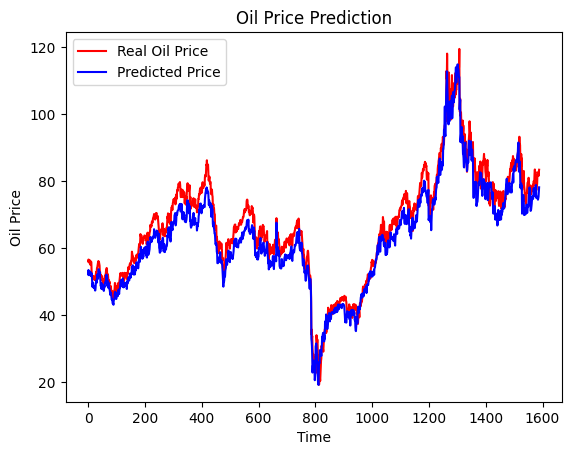

In [98]:
plt.plot(real_price, color='red', label='Real Oil Price')
plt.plot(predictions, color='blue', label='Predicted Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.legend()
plt.show()

In [ ]:
input_data_test = []
for i in range(6):
    feature = float(input(f"Enter value for feature {i+1}: "))
    input_data_test.append(feature)
    
testing_data = pd.Series(input_data_test, index=['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'])

In [ ]:
input_data_test = testing_data.values.reshape(1, -1).repeat(61, axis=0) 
input_data_test_scaled = sc.transform(input_data_test)
predicted_price_test = model.predict(np.array([input_data_test_scaled]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
predicted_price_test = np.array(predicted_price_test).reshape(-1)

In [ ]:
predicted_price_test[0]

29.523085